# Proyek ini akan membuat model dari dataset Time Series untuk memprediksi tingkat polusi PM2.5 untuk periode kedepan

Mengimport Library yang akan digunakan

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback


Membaca Dataset CSV Ke dalam DataFrame

In [171]:
df = pd.read_csv('./tirupati_air_quality.csv')


Melihat detail dari Dataset

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59150 entries, 0 to 59149
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   From Date        59150 non-null  object 
 1   To Date          59150 non-null  object 
 2   PM2.5 (ug/m3)    54323 non-null  float64
 3   PM10 (ug/m3)     54450 non-null  float64
 4   NO (ug/m3)       55153 non-null  float64
 5   NO2 (ug/m3)      55100 non-null  float64
 6   NOx (ppb)        55315 non-null  float64
 7   NH3 (ug/m3)      53564 non-null  float64
 8   SO2 (ug/m3)      54285 non-null  float64
 9   CO (mg/m3)       54673 non-null  float64
 10  Ozone (ug/m3)    54567 non-null  float64
 11  Benzene (ug/m3)  55213 non-null  float64
 12  Toluene (ug/m3)  55213 non-null  float64
 13  Temp (degree C)  55113 non-null  float64
 14  RH (%)           55281 non-null  float64
 15  WS (m/s)         55299 non-null  float64
 16  WD (deg)         54656 non-null  float64
 17  SR (W/mt2)  

Melihat Grafik Plot dari PM2.5

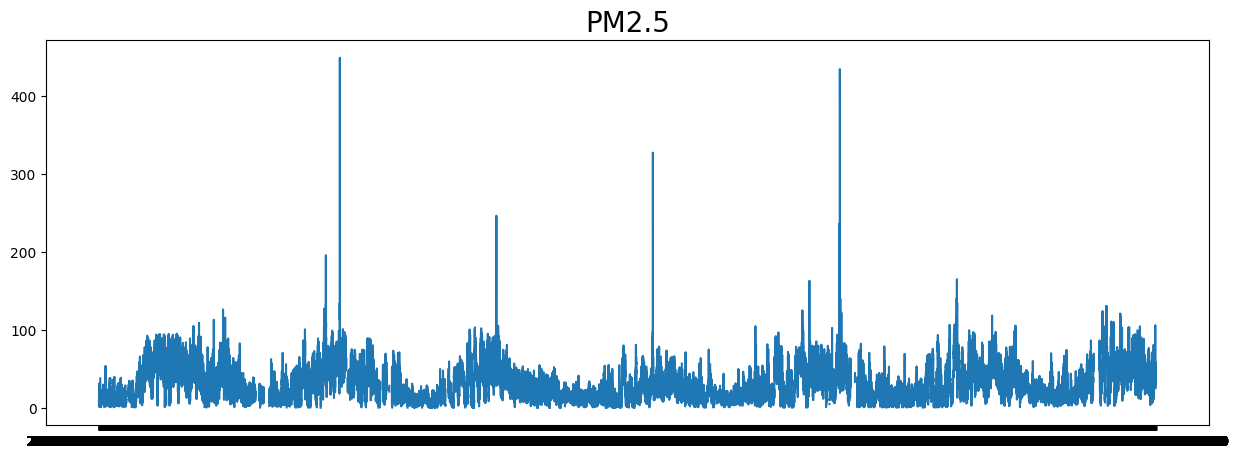

In [173]:
date = df['From Date'].values
PM = df['PM2.5 (ug/m3)'].values

plt.figure(figsize=(15,5))
plt.plot(date, PM)
plt.title('PM2.5',
          fontsize=20);

Menyalin Dataset untuk Preprocessing

In [174]:
X = df.copy(deep=True)

Menghapus setiap attribut Dataset kecuali Date dan PM2.5

In [175]:
column_name = X.columns.values

In [176]:
delcol = column_name[3:23]

In [177]:
delcol

array(['PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)',
       'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)',
       'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Temp (degree C)', 'RH (%)',
       'WS (m/s)', 'WD (deg)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)',
       'Xylene (ug/m3)', 'RF (mm)', 'AT (degree C)'], dtype=object)

In [178]:
delete = []
for col in delcol:
  delete.append(col)

In [179]:
delete

['PM10 (ug/m3)',
 'NO (ug/m3)',
 'NO2 (ug/m3)',
 'NOx (ppb)',
 'NH3 (ug/m3)',
 'SO2 (ug/m3)',
 'CO (mg/m3)',
 'Ozone (ug/m3)',
 'Benzene (ug/m3)',
 'Toluene (ug/m3)',
 'Temp (degree C)',
 'RH (%)',
 'WS (m/s)',
 'WD (deg)',
 'SR (W/mt2)',
 'BP (mmHg)',
 'VWS (m/s)',
 'Xylene (ug/m3)',
 'RF (mm)',
 'AT (degree C)']

In [180]:
X.drop(['To Date'], axis=1, inplace=True)
X.drop(delete, axis=1, inplace=True)

Mengecek Dataset yang sudah dilakukan *drop*

In [181]:
X.head()

,From Date,PM2.5 (ug/m3)
0,2016-07-01 10:00:00,10.67
1,2016-07-01 11:00:00,2.00
2,2016-07-01 12:00:00,NaN
3,2016-07-01 13:00:00,NaN
4,2016-07-01 14:00:00,20.50


Menghilangkan sampel yang bernilai NaN

In [182]:
X = X.dropna(axis=0)

Melihat dataset dengan sampel tanpa NaN

In [183]:
X.head()

,From Date,PM2.5 (ug/m3)
0,2016-07-01 10:00:00,10.67
1,2016-07-01 11:00:00,2.00
4,2016-07-01 14:00:00,20.50
5,2016-07-01 15:00:00,15.25
6,2016-07-01 16:00:00,11.67


Membuat fungsi windowed_dataset

In [184]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Melakukan normalisasi menggunakan MinMaxScaler

In [185]:
mms = MinMaxScaler()
val = X['PM2.5 (ug/m3)'].values
val = val.reshape(-1, 1)
X_scaled = mms.fit_transform(val)

In [186]:
X_scaled

array([[0.02319421],
       [0.00389538],
       [0.04507513],
       ...,
       [0.09794101],
       [0.0690039 ],
       [0.05731775]])

Memasukkan kedua kolom dalam variabel X dan y untuk training

In [187]:
X_date = X['From Date'].values
y_quality = X_scaled

In [188]:
y_quality

array([[0.02319421],
       [0.00389538],
       [0.04507513],
       ...,
       [0.09794101],
       [0.0690039 ],
       [0.05731775]])

Membagi dataset menjadi 80% training set dan 20% validation set

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X_date, y_quality, test_size=0.2, shuffle=False)

Menentukan Threshold Mean Absolute Error (MAE) dan membuat fungsi Callback

In [195]:
threshold_mae = ((y_quality.max() - y_quality.min()) * 10/100)
print("Threshold MAE dari data adalah: " + str(threshold_mae))

Threshold MAE dari data adalah: 0.1


In [191]:
# Callback untuk menghentikan training ketika MAE dari model <10% skala data.
class MAE_Callback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae:
          self.model.stop_training = True
          print("\n[MAE & MAE Validasi yang didapatkan senilai %2.2f%% & %2.2f%% dari skala data, training dihentikan.]\n"
                % ((logs.get('mae')*10/threshold_mae), (logs.get('val_mae')*10/threshold_mae)))

        else:
          print("\n[MAE & MAE Validasi yang didapatkan senilai %2.2f%% & %2.2f%% dari skala data, lanjut ke epoch berikutnya]\n"
                % ((logs.get('mae')*10/threshold_mae), (logs.get('val_mae')*10/threshold_mae)))

mae_callback = MAE_Callback()

Membuat Model


In [192]:
train_set = windowed_dataset(y_train, window_size=30, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=30, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

Melakukan Training

In [193]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(
    train_set,
    validation_data=val_set,
    callbacks=[mae_callback],
    epochs=10)

Epoch 1/10
    434/Unknown - 40s 81ms/step - loss: 0.0018 - mae: 0.0417
[MAE & MAE Validasi yang didapatkan senilai 4.17% & 4.39% dari skala data, training dihentikan.]

435/435 [==============================] - 44s 91ms/step - loss: 0.0018 - mae: 0.0417 - val_loss: 0.0018 - val_mae: 0.0439


--- Menampilkan output dari training ---


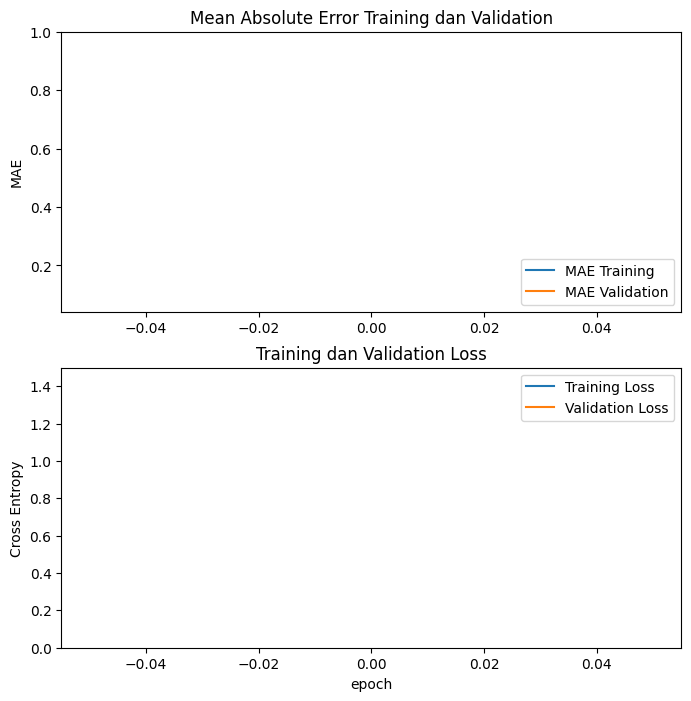

In [194]:
# Menampilkan output dari training

message = '--- Menampilkan output dari training ---'
print(message)

mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='MAE Training')
plt.plot(val_mae, label='MAE Validation')
plt.legend(loc='lower right')
plt.ylabel('MAE')
plt.ylim([min(plt.ylim()),1])
plt.title('Mean Absolute Error Training dan Validation')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training dan Validation Loss')
plt.xlabel('epoch')
plt.show()